In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from IPython.display import display_html

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import re

from datetime import date
import gzip
import numpy as np
import pandas as pd
pd.set_option("display.max_columns",100, "display.width",2000, "display.max_colwidth",100)
import pickle
from scipy.sparse import csr_matrix, vstack
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.utils import class_weight
from termcolor import colored
from sklearn.model_selection import train_test_split
import sklearn.metrics

import optuna
optuna.logging.set_verbosity(optuna.logging.WARN) #INFO, WARN
import lightgbm as lgb; lgb.__version__

import pickle

/Users/divyanori/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'3.2.1'

Parameters

In [3]:
prm = dict(
  #number of Optuna trials
  NTRIALS = 100,
  
  #number of boosted trees to be created
  NBOOST = 50,

  #number of classes in response variable
  NCLASS = 3,

  #morgan fingerpring bit length
  FP_BITS = 2048
)

offs = max(map(len,prm.keys()))
print("Parameters")
for k,v in prm.items():
  print(f"{k:>{offs}}: {v}")

del k, v, offs

Parameters
NTRIALS: 100
 NBOOST: 50
 NCLASS: 3
FP_BITS: 2048


Reading Data

In [4]:
input_df = pd.read_csv("protac.csv").reset_index(drop=True)
input_df = input_df.rename(columns={"E3 ligase":"E3ligase"})
print("input_df: {:,} x {:,}".format(*input_df.shape), "(input df) \n")

print("Counts of distinct values in columns")
for x in ["Target","E3ligase"]:
  tmp = input_df.groupby(x, as_index=False).size().sort_values("size", ascending=False, ignore_index=True)
  print(f"col:{x}  (#unique:{tmp.shape[0]:,})")
  print(tmp.head(20).T, "\n")

del tmp

input_df: 3,939 x 84 (input df) 

Counts of distinct values in columns
col:Target  (#unique:289)
         0     1     2    3     4    5    6        7     8     9       10    11    12     13     14    15          16                17   18    19
Target   ER  BRD4  CDK4   AR  CDK6  BTK  ALK  BCR-ABL  BRD3  BRD2  BCL-xL  MEK1  CDK2  PARP1  HDAC6  BRD9  BRAF V600E  EGFR L858R/T790M  FAK  CDK9
size    182   164   143  141   139  106   97       96    77    77      77    76    70     63     60    53          53                52   52    52 

col:E3ligase  (#unique:12)
            0     1      2     3     4    5    6       7       8       9       10    11
E3ligase  CRBN   VHL  cIAP1  XIAP  MDM2  AhR  IAP  DCAF15  DCAF16  RNF114  DCAF11  RNF4
size      2571  1152    122    34    30    9    5       4       4       4       3     1 



Creating E3 Ligase Classes

In [5]:
for i in range(len(input_df["E3ligase"])):
    if 'IAP' in str(input_df.loc[i].at["E3ligase"]):
        input_df.at[i,'E3ligase']='IAP'
    elif 'DCAF' in str(input_df.loc[i].at["E3ligase"]):
        input_df.at[i,'E3ligase']='DCAF'
    elif 'RNF' in str(input_df.loc[i].at["E3ligase"]):
        input_df.at[i,'E3ligase']='RNF'

tmp = input_df.groupby('E3ligase', as_index=False).size().sort_values("size", ascending=False, ignore_index=True)
print(f"col:{'E3ligase'}  (#unique:{tmp.shape[0]:,})")
print(tmp.head(20).T, "\n")
del tmp

col:E3ligase  (#unique:7)
             0     1    2     3     4    5    6
E3ligase  CRBN   VHL  IAP  MDM2  DCAF  AhR  RNF
size      2571  1152  161    30    11    9    5 



In [6]:
print('Number of Rows with explicit DC50: ' + str((input_df.shape[0] - input_df['DC50 (nM)'].isna().sum())))
#input_df = input_df.dropna(subset=['DC50 (nM)',"Percent degradation (%)"],how='all')
input_df = input_df.dropna(subset=['DC50 (nM)'])
print("input_df: {:,} x {:,}".format(*input_df.shape), "(input df) \n")

Number of Rows with explicit DC50: 638
input_df: 638 x 84 (input df) 



Preparing Features

Target and E3 Ligase

In [7]:
model_df = pd.concat([
    pd.get_dummies(input_df["Target"], prefix="tgt"),
    pd.get_dummies(input_df["E3ligase"], prefix="e3")
  ], axis=1).reset_index(drop=True)

print("model_df: {:,} x {:,}".format(*model_df.shape), "(target and E3ligase OHE features)")

model_df: 638 x 89 (target and E3ligase OHE features)


Molecular Fingerprint

In [8]:
def get_morgan_fp(smiles:str, nbits:int=prm['FP_BITS']):
  m = Chem.MolFromSmiles(smiles)
  fingerprint = AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=nbits)
  array = np.zeros((0,), dtype=np.int8)
  DataStructs.ConvertToNumpyArray(fingerprint, array)
  return array

fingerprints = [get_morgan_fp(x).tolist() for x in input_df["Smiles"]]
fp_df = pd.DataFrame(fingerprints, columns=["sm"+str(n) for n in range(1,prm['FP_BITS']+1)])
print("model_df: {:,} x {:,}".format(*model_df.shape))

#assert model_df.columns == smiles_df.columns

model_df = pd.concat([model_df,fp_df],axis=1)
print("fp_df: {:,} x {:,}".format(*fp_df.shape))
print("model_df: {:,} x {:,}".format(*model_df.shape), "(added fingerprint features)")


model_df: 638 x 89
fp_df: 638 x 2,048
model_df: 638 x 2,137 (added fingerprint features)


Cell Type

In [9]:
celltypes = []
for i in range(input_df.shape[0]):
    row = str(input_df.iloc[i].to_list())
    cell = re.findall('[\w\.;/-]+ cells', row)
    if len(cell)==0:
        celltypes.append('Unknown')
    else:
        celltypes.append(cell[0][:-6])

def most_frequent(List):
    return max(set(List), key = List.count)

print("Most Common Cell Type: " + most_frequent(celltypes))

print('Cell Types: ' + str(set(celltypes)))
len(set(celltypes))
model_df['ct'] = celltypes
model_df = pd.get_dummies(model_df, prefix='ct')
model_df
print("\nmodel_df: {:,} x {:,}".format(*model_df.shape), "(added cell type feature)")

Most Common Cell Type: K562
Cell Types: {'PBMC', 'HeLa/HEK293', 'MV4-11', 'NCI-H2030', 'LNCaP/VCaP/22Rv1', 'PC9', 'Mino', 'OVCAR8/HeLa', 'MCF7', 'A549/Hep3B2.1-7/SNU-387', 'T47D/MB-MDA-231', 'Pfeiffer/DOHH2/K562', 'MM.1S', 'MOLT-4/platelets', '205', 'Molm-16/SU-DHL-1', 'MOLT-4', 'MCF7/MDA-MB-231', 'MDA-MB-231', 'SR', '4935', 'U251', 'OCI-AML2/OCI-AML3/Ramos', 'SK-MEL-246', 'Namalwa/CA-46', 'TM3/PA1/MDA-MB-436', 'PC3', 'H3122/Karpas299/Kelly', 'H1666/CAL-12T', 'SW1573', 'VCaP', 'H3255', 'A549', 'MV4;11', 'Jurkat/MOLT-4/U937', 'XLA', 'PC-3', 'HT-29/SK-MEL-28', 'EOL-1', '22Rv1', 'THP-1', 'KM12/HEL', 'MM.1S/MDA-MB-231', 'MCF-7', 'THP1', 'Sk-Mel-28', 'K562', 'WI38', 'NCI-H661/NCI-H838', '22Rv1/VCaP/LnCaP95', 'MM', 'A375', 'Jurkat', 'SW480', 'KYSE520/MV4;11', 'HCC-827', 'HCC827/H3255', 'EOL-1/A-204', 'KYSE-270', 'SK-MEL-28', 'SU-DHL-1/NCI-H2228', 'Hs578t', 'Ramos', 'HLE/HuH-7/SNU-423', 'HCC827', 'HLF/SNU-398/HUCCT1', 'MV-4-11/NCI-H1568', 'LNCaP/VCaP', 'MCF-7/T47D', 'LNCaP/Ramos', 'H1975', 'N

109

,tgt_ABL1,tgt_ADRA1A,tgt_AKT1,tgt_AKT2,tgt_AKT3,tgt_ALK,tgt_ALK G1202R,tgt_AR,tgt_AR-V7,tgt_AURKA,tgt_BCL-xL,tgt_BCL2,tgt_BCR-ABL,tgt_BLK,tgt_BRAF G466V,tgt_BRAF G469A,tgt_BRAF V600E,tgt_BRD2,tgt_BRD3,tgt_BRD4,tgt_BRD4 BD1,tgt_BRD7,tgt_BRD9,tgt_BTK,tgt_BTK C481S,tgt_CD147,tgt_CDK19,tgt_CDK2,tgt_CDK4,tgt_CDK6,tgt_CDK8,tgt_CDK9,tgt_CRBN,tgt_Cdc20,tgt_EED,tgt_EGFR,tgt_EGFR L858R,tgt_EGFR L858R/T790M,tgt_EGFR e19d,tgt_ER,tgt_ERRalpha,tgt_EZH2,tgt_FAK,tgt_FKBP12,tgt_GCN5,tgt_GSK-3beta,tgt_GSK3A,tgt_HDAC3,tgt_HDAC6,tgt_HMGCR,...,ct_MOLT-4/platelets,ct_MV-4-11,ct_MV-4-11/NCI-H1568,ct_MV4-11,ct_MV4;11,ct_Mino,ct_Molm-16,ct_Molm-16/SU-DHL-1,ct_NAMALWA,ct_NAMALWA/XLA,ct_NCI-H2030,ct_NCI-H2030/MIAPaCa-2/SW1573,ct_NCI-H23/NCI-H358,ct_NCI-H661/NCI-H838,ct_Namalwa/CA-46,ct_OCI-AML2/OCI-AML3/Ramos,ct_OVCAR8/HeLa,ct_PBMC,ct_PC-3,ct_PC-3/LNCaP/MDA-MB-231,ct_PC3,ct_PC3-S1,ct_PC9,ct_Pfeiffer/DOHH2/K562,ct_RI-1,ct_Ramos,ct_Ramos/THP-1,ct_SK-MEL-246,ct_SK-MEL-28,ct_SR,ct_SRD15,ct_SU-DHL-1/NCI-H2228,ct_SUM149,ct_SW1573,ct_SW480,ct_SW620,ct_Sertoli/germ,ct_Sk-Mel-28,ct_T47D/MB-MDA-231,ct_THP-1,ct_THP1,ct_TM3/PA1/MDA-MB-436,ct_Tu-I,ct_U251,ct_Unknown,ct_VCaP,ct_WI38,ct_XLA,ct_Z138/HBL-1/Mino,ct_hPBMC
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
634,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
635,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
636,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



model_df: 638 x 2,246 (added cell type feature)


Response Variable (DC50)

In [10]:
#add and process DC50 column

model_df['resp'] = list(input_df['DC50 (nM)'])
model_df['resp'] = model_df["resp"].str.replace("[<=>]","")
model_df['resp'] = model_df["resp"].str.replace("\(n/a\)","0")
model_df['resp'] = model_df["resp"].str.replace('[\d]+[-~]',"")
model_df = model_df.loc[~model_df['resp'].str.contains('[a-zA-Z]')]

/var/folders/vs/8ts0hp5d0wzf8zdrzyqly4840000gn/T/ipykernel_16999/1778872113.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  model_df['resp'] = model_df["resp"].str.replace("[<=>]","")
/var/folders/vs/8ts0hp5d0wzf8zdrzyqly4840000gn/T/ipykernel_16999/1778872113.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  model_df['resp'] = model_df["resp"].str.replace("\(n/a\)","0")
/var/folders/vs/8ts0hp5d0wzf8zdrzyqly4840000gn/T/ipykernel_16999/1778872113.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  model_df['resp'] = model_df["resp"].str.replace('[\d]+[-~]',"")


Split DC50 by Cell Type

In [11]:
out_nochange = []
out_v1 = []
out_v2 = []
for row in model_df.to_dict(orient="records"):
  #no slashes
  if "/" not in row["resp"]:
    out_nochange.append(row)
    continue
  
  #slashes in resp matched by a column with ct which has same number of slashes
  lst = [k for k,v in row.items() if k.startswith("ct") and "/" in k and v==1]
  assert len(lst) in [0,1]
  if len(lst) == 1:
    #test.append((lst[0],row["resp"]))
    cols = lst[0].split("/")
    vals = row["resp"].split("/")
    assert len(cols)==len(vals)
    assert len(cols) in [2,3]
    
    #adding 2 or 3 rows
    for c,v in zip(cols,vals):
      dct = row.copy()
      k = c if c.startswith("ct_") else "ct_"+c
      dct[k] = 1
      dct["resp"] = v
      del dct[lst[0]]
      out_v1.append(dct)
  else:
    vals = row["resp"].split("/")
    dct = row.copy()
    dct["resp"] = vals[0]
    out_v2.append(dct)
    
    
model_df = pd.DataFrame(out_nochange+out_v1+out_v2)
model_df = model_df.fillna(0)
model_df['resp'] = pd.to_numeric(model_df['resp'])

DC50 Distribution and Cutoff Determination

[Text(0.5, 0, 'DC50 Value')]

[Text(0, 0.5, 'Count')]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


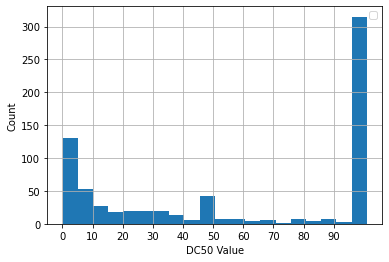

In [12]:
#dropping rows with outlier DC50 values
model_df.drop(model_df.index[model_df['resp'] <= 0], inplace=True)
model_df.loc[model_df.resp>100, 'resp'] = 101

ax = model_df['resp'].astype(float).hist(bins = 20)
ax.set(xlabel=f"DC50 Value")
ax.set(ylabel=f"Count")
ax.legend(loc="upper right")
ax.set_xticks(ticks=range(0, 100, 10), minor=False)

In [13]:
model_df.loc[model_df.resp<=10.0, 'resp_categorical'] = '0'
#model_df.loc[(model_df.resp<=100.0).any() and (model_df.resp>10.0).any(), 'resp_categorical'] = '1'
model_df.loc[model_df.resp>100.0, 'resp_categorical'] = '2'
model_df['resp_categorical'] = model_df['resp_categorical'].fillna('1')
model_df.drop(model_df.tail(1).index,inplace=True) # drop last row of nans

Add Controls From MOSES

In [14]:
# with open("data/moses_subset.smi") as file:
#     moses_smi = file.readlines()
#     moses_smi = [line.rstrip() for line in moses_smi]
# fingerprints = [get_morgan_fp(y).tolist() for y in moses_smi]
# start_buffer = [0 for i in range(list(model_df.columns).index('sm1'))]
# end_buffer = [0 for j in range(list(model_df.columns).index('resp_categorical') - list(model_df.columns).index(f"sm{prm['FP_BITS']}"))]
# rows = [start_buffer+fingerprints[i]+end_buffer for i in range(len(fingerprints))]
# moses_df = pd.DataFrame(rows, columns=model_df.columns)

# model_df = pd.concat([model_df,moses_df],ignore_index=True)
# print("moses_df: {:,} x {:,}".format(*moses_df.shape))
# print("model_df: {:,} x {:,}".format(*model_df.shape), "(added moses control points)")

In [15]:
model_df.to_csv(f'output_no_moses/model_df_{prm["FP_BITS"]}.csv')

Model Matrices

In [16]:
train,test = train_test_split(model_df, random_state=1, test_size=.2)

features = train.columns.tolist()[1:-1]  #dropping "resp"
print(f"nfeatures: {len(features):,}")

X_train = train.drop(["resp_categorical","resp"], axis=1).values
print("x train before: {:,} x {:,}".format(*X_train.shape), "(x df) \n")
y_train = train["resp_categorical"].values
y_train = np.array([int(x) for x in y_train])

X_test = test.drop(["resp_categorical","resp"], axis=1).values
y_test = test["resp_categorical"].values
y_test = np.array([int(x) for x in y_test])

del train, test

#save features to a pickle file
with open("features","wb") as feat_file:
    pickle.dump(features, feat_file)

nfeatures: 2,297
x train before: 566 x 2,297 (x df) 



In [17]:
print("[train] X: {:,} x {:,}".format(*X_train.shape,y_train.shape))
print("[test] X: {:,} x {:,}".format(*X_test.shape,y_train.shape))

[train] X: 566 x 2,297
[test] X: 142 x 2,297


HyperParam Optimization via Optuna

In [18]:
class LightGBM:
  
  def __init__(self):
    self.best_booster = None
    self._booster = None
    
    self.X = X_train
    self.y = y_train
    self.nclass = 3
    self.wts = class_weight.compute_sample_weight(class_weight="balanced", y=self.y)
    self.prm_lgb = {      
      "objective": "multiclass",
      "metric": None, 
      "verbosity": -1,
      "num_class": self.nclass,
      "boosting_type": "gbdt",
      "force_row_wise": True,
      "min_gain_to_split": .5,
    }
  
  def __call__(self, trial):    
    dtrain = lgb.Dataset(self.X, self.y, weight=self.wts)
    prm_lgb = {
      **self.prm_lgb
      , **{
        "learning_rate": trial.suggest_loguniform("learning_rate", .01, .3),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1E-3, 1.),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", .5, 3.),
        "num_leaves": trial.suggest_int("num_leaves", 8, 32),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 100),
        "feature_fraction": trial.suggest_uniform("feature_fraction", .3, .6),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", .4, 1.),
        "bagging_freq": trial.suggest_int("bagging_freq", 2, 6),
        "boosting_type":trial.suggest_categorical("boosting_type",["gbdt","rf"])
      }
    }
    
    def f1_eval(preds, dtrain):
      preds = preds.reshape(self.nclass,-1).T
      f_score = f1_score(dtrain.get_label(),preds.argmax(axis=1),average="micro")
      return "f1_score",f_score,True
    
    early_stop = lgb.early_stopping(20, first_metric_only=False, verbose=False)
    eval_hist = lgb.cv(prm_lgb, dtrain, nfold=5, seed=12345, num_boost_round=prm["NBOOST"],
                           feval=f1_eval, callbacks=[early_stop])
    
    return eval_hist["f1_score-mean"][-1]
  
  def callback(self, study, trial):
    if study.best_trial==trial:
      print(f"{study.best_trial.number} ({study.best_trial.values[0]:.3f})", end=" ", flush=True)
      self.best_booster = self._booster
      return
    if trial.number%20==0:
      print(f"{trial.number}", end=" ", flush=True)

  
objective = LightGBM()
print(f"best trial ({prm['NTRIALS']}):", end=" ")
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), 
                              sampler=optuna.samplers.TPESampler(seed=1234), direction="maximize")
study.optimize(objective, n_trials=prm["NTRIALS"], callbacks=[objective.callback])

best trial (100): 0 (0.452) 1 (0.468) 5 (0.488) 6 (0.505) 10 (0.613) 12 (0.617) 14 (0.636) 20 32 (0.647) 36 (0.648) 40 44 (0.648) 51 (0.650) 52 (0.655) 60 79 (0.661) 80 82 (0.664) 

In [19]:
trials_df = study.trials_dataframe(attrs=("params","user_attrs","value","duration"))
for y in ["params","user_attrs"]:
  trials_df.columns = [x[1+len(y):] if x.startswith(y) else x for x in trials_df.columns]
trials_df["duration"] = trials_df["duration"].apply(lambda x:x.total_seconds())
with pd.option_context("display.max_rows",6, "display.float_format","{:.4f}".format):
  display_html(trials_df.sort_values("value", ascending=False))
print(f"  duration: {trials_df['duration'].sum()/60:.1f}min")

trials_df.groupby("boosting_type").agg(meanv=("value","mean"),sdv=("value","std"))

,bagging_fraction,bagging_freq,boosting_type,feature_fraction,lambda_l1,lambda_l2,learning_rate,min_data_in_leaf,num_leaves,value,duration
82,0.8616,4,gbdt,0.4935,0.0033,1.3907,0.2304,51,11,0.6643,0.9701
95,0.8542,4,gbdt,0.4474,0.0025,1.5005,0.2813,50,24,0.6642,1.0053
79,0.8362,4,gbdt,0.4951,0.0037,1.2399,0.2682,51,13,0.6608,1.1211
...,...,...,...,...,...,...,...,...,...,...,...
2,0.6383,5,rf,0.4954,0.0702,0.5723,0.0346,97,17,0.4434,0.4558
3,0.5313,6,rf,0.5114,0.0203,2.1046,0.1922,85,11,0.4187,0.4769
4,0.4260,4,rf,0.4600,0.0036,0.5443,0.0123,80,24,0.4115,0.3733


  duration: 1.6min


,meanv,sdv
boosting_type,,
gbdt,0.611108,0.046281
rf,0.489980,0.047734


In [20]:
print("Best Boosted Tree Model Mean F1 Score: " + str(trials_df[trials_df['boosting_type']=='gbdt']['value'].max()))
print("Best Random Forest Model Mean F1 Score: " + str(trials_df[trials_df['boosting_type']=='rf']['value'].max()))

Best Boosted Tree Model Mean F1 Score: 0.6642912591212544
Best Random Forest Model Mean F1 Score: 0.5564974382859804


Model Training

In [21]:
ind = np.argmax(trials_df["value"].values)
lgb_prm = study.trials[ind].params
lgb_prm = {**lgb_prm, 
  **{
    "objective": "multiclass",
    "metric": None,
    "num_class": 3,
    "force_row_wise": True, 
    "verbosity": -1,
    "min_gain_to_split": .5,
  }
}

def f1_eval(preds, dtrain):
  preds = preds.reshape(prm['NCLASS'],-1).T
  f_score = f1_score(dtrain.get_label(),preds.argmax(axis=1),average="micro")
  return "f1_score",f_score,True

wt = class_weight.compute_sample_weight(class_weight="balanced", y=y_train)
dtrain = lgb.Dataset(X_train, y_train, weight=wt)
#early_stop = lgb.early_stopping(20, first_metric_only=False, verbose=True)
model = lgb.train(lgb_prm, dtrain, feval=f1_eval,
                      num_boost_round=prm["NBOOST"])

del ind, lgb_prm, wt

Results

In [22]:
train_pred = model.predict(X_train)
print(f"train roc_ovo {roc_auc_score(y_train,train_pred,multi_class='ovo'):.4f}    train roc_ovr {roc_auc_score(y_train,train_pred,multi_class='ovr'):.4f}\n")
y_train_pred = [train_pred[i].argmax(axis=0) for i in range(len(train_pred))]

test_pred = model.predict(X_test)
print(f"test roc_ovo {roc_auc_score(y_test,test_pred,multi_class='ovo'):.4f}    test roc_ovr {roc_auc_score(y_test,test_pred,multi_class='ovr'):.4f}\n")
y_test_pred = [test_pred[i].argmax(axis=0) for i in range(len(test_pred))]

print(classification_report(y_test,y_test_pred))

train roc_ovo 0.9145    train roc_ovr 0.9146

test roc_ovo 0.8367    test roc_ovr 0.8422

              precision    recall  f1-score   support

           0       0.63      0.63      0.63        43
           1       0.64      0.58      0.61        43
           2       0.78      0.84      0.81        56

    accuracy                           0.70       142
   macro avg       0.68      0.68      0.68       142
weighted avg       0.69      0.70      0.69       142



In [23]:
metrics = sklearn.metrics.precision_recall_fscore_support(y_test, y_test_pred)
metrics_df = pd.DataFrame(metrics).transpose()
metrics_df.columns = ['precision','recall','f1-score','support']
metrics_df.to_csv(f'output_no_moses/metrics_{prm["FP_BITS"]}.csv')

In [24]:
from optuna.visualization import plot_parallel_coordinate, plot_param_importances, plot_contour, plot_optimization_history

plot_param_importances(study)
plot_optimization_history(study)
plot_parallel_coordinate(study)

Protein Degradation Prediction Function

In [25]:
def predictProteinDegradation(smiles, cellType='HeLa', target='ER', e3Ligase='IAP'):
    m = Chem.MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=prm['FP_BITS'])
    fp_array = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fingerprint, fp_array)
    input = list(0 for i in range(88)) + list(fp_array) + list(0 for i in range(161))

    #need to add a 1 for target and a 1 for cell type
    tgt_ind = features.index("tgt_"+target)
    ct_ind = features.index("ct_"+cellType)
    e3_ind = features.index("e3_"+e3Ligase)
    input[tgt_ind] = 1
    input[ct_ind] = 1
    input[e3_ind] = 1

    output = model.predict([input])
    return output[0].argmax()

Save Model

In [26]:
Pkl_Filename = f"output_no_moses/Protac_Scoring_Model_{prm['FP_BITS']}.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

In [27]:
Feature_Filename = f"output_no_moses/features_{prm['FP_BITS']}.pkl"  
features = model_df.columns.tolist()[:-1]

with open(Feature_Filename, 'wb') as file:  
    pickle.dump(features, file)